<a href="https://colab.research.google.com/github/Santosh-16k/who_is_batman/blob/master/who_is_batman_src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who is Batman?

The first step is to import the relevant libraries. Currently (in Aug, 2020), Colab does not have support for fastai2 So, we have to install it before using.

In [ ]:
!pip install fastai2 > /dev/null
from fastai2.vision.all import *
from pathlib import Path 
from fastai2.vision.widgets import *

In [ ]:
!ls 

sample_data


Next, we have to upload the dataset, so that we can use it in Colab. This opens up a widget to help you select and upload the dataset, in our case it's batman.zip.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving batman.zip to batman.zip


In [ ]:
!ls

batman.zip  sample_data


Great, the file is uploaded. We have to extract it before we can use it.

In [ ]:
!unzip batman.zip

Archive:  batman.zip
   creating: batman/ben_affleck/
 extracting: batman/ben_affleck/_5cc19c1c-52ea-11ea-a3cd-8211a7b3c8e4.jpg  
  inflating: batman/ben_affleck/1_batman-ben-affleck-justice-league-e1528776943822.jpg  
  inflating: batman/ben_affleck/1527767518-batman.jpg  
  inflating: batman/ben_affleck/3d90a65aa7e17c0cc9ab559fec53eb123363cd06.jpg  
  inflating: batman/ben_affleck/4k-batman-ben-affleck-em.jpg  
  inflating: batman/ben_affleck/6677682_preview.png  
  inflating: batman/ben_affleck/Annotation_0.png  
  inflating: batman/ben_affleck/Annotation_1.png  
  inflating: batman/ben_affleck/Annotation_2.png  
  inflating: batman/ben_affleck/Annotation_3.png  
  inflating: batman/ben_affleck/Annotation_4.png  
  inflating: batman/ben_affleck/Annotation_5.png  
  inflating: batman/ben_affleck/Annotation_6.png  
  inflating: batman/ben_affleck/Annotation_7.png  
  inflating: batman/ben_affleck/Annotation_8.png  
  inflating: batman/ben_affleck/Annotation_9.png  
  inflating: batman

In [ ]:
!ls

batman	batman.zip  sample_data


Let's set the variables with the appropriate path and data.

In [ ]:
actors = ['christian_bale', 'ben_affleck']
path = Path('batman')

In [ ]:
path

Path('batman')

In [ ]:
fns = get_image_files(path)

In [ ]:
fns

(#60) [Path('batman/christian_bale/Annotation (2).png'),Path('batman/christian_bale/dark_knight_rises_1-1.jpg'),Path('batman/christian_bale/Annotation_4.png'),Path('batman/christian_bale/587332.jpg-r_640_360-f_jpg-q_x-xxyxx.jpg'),Path('batman/christian_bale/Batman-Begins.jpg'),Path('batman/christian_bale/245e63068ffc53936fdf22f99eba88fc--christian-bale-batman-dark-knights.jpg'),Path('batman/christian_bale/christian-bale-the-dark-knight-2008-RN7GWM.jpg'),Path('batman/christian_bale/Annotation_5.png'),Path('batman/christian_bale/Annotation_1.png'),Path('batman/christian_bale/intro-1565117963.jpg')...]

Opening a sample image for viewing

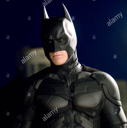

In [ ]:
img = Image.open('batman/christian_bale/christian-bale-the-dark-knight-2008-RN7GWM.jpg')
img.to_thumb(128,128)

Now, we have the classes in variable actors and path to image files in fns

We need to create a Datablock, to correctly map the input image with its respective labels, split the data for training and testing and apply data augmentation to it.

In [ ]:
batmans = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=TrainTestSplitter(test_size=0.2, random_seed=42),
    get_y=parent_label)

In [ ]:
batmans = batmans.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())

The above code tells the Datablock that the dataset is comprised of Image and the output block is category. It gives provides a function to get the Image data and `splitter` is defined to split the data with 20% data kept reserved for Testing. The `parent_label` is provided to the parameter`get_y` It indicates that the label for an image is the name of its parent folder.

To iterate over the dataset, we create a DataLoader with batch size 4.

In [ ]:
dls = batmans.dataloaders(path, bs=4)

Let's look at a batch

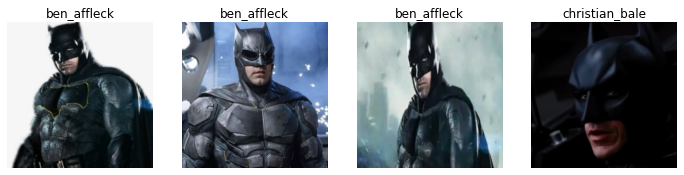

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

We define a learner with a pretrained `resnet18` architecture. With this, we fine tune the network for 2 epochs.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)


epoch,train_loss,valid_loss,error_rate,time
0,1.304225,0.351740,0.166667,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.776903,0.131666,0.083333,00:01
1,0.680475,0.091201,0.083333,00:01


This suggests an accuracy of ~92% on the validation set. This seems quite a good network as it used only 24 images for each class to train.

Let's have a look at the confusion matrix.

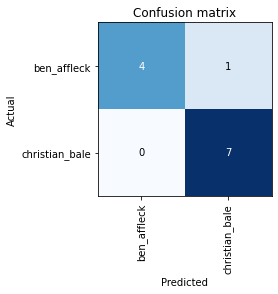

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

So, of the 12 images in the validation set, the network incorrectly identified only one image. The rest were classified correctly.

Let's have a look at the image for which the network has low confidence.

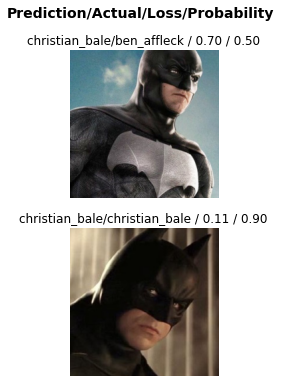

In [ ]:
interp.plot_top_losses(2, nrows=2)

# Test the Model

The network performance is impressive. Let's take add code to upload and test the prediction capability of the model.

In case you want to download the .pkl file. Uncomment the following lines

In [ ]:
# learn.export()

In [ ]:
# path = Path()
# path.ls(file_exts='.pkl')

In [ ]:
# learn_inf = load_learner(path/'export.pkl')


In [ ]:
# from google.colab import files
# files.download('export.pkl') 

This adds a widget to upload image. Search for a batman image on Google and upload it using the uploader widget.

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(uploader.data[0])
actor,_,probs = learn.predict(img)
print(f"Who's the actor behind mask?: {actor}.")
print(f"With a probability of {probs[1].item():.6f}")

Who's the actor behind mask?: christian_bale.
With a probability of 0.909068


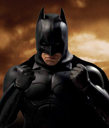

In [ ]:
img.to_thumb(128,128)

Great! this is what we expected. It's Christian Bale.

# Summary
Now, you can easily find the actor hiding behind the mask. 

This is an interesting problem of classification based on partial facial features. It demonstrates that with transfer learning, the deep learning model used just 24 images per class to get an accuracy of about 92%.